In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib.gridspec import GridSpec
import glob

from dust_extinction.dust import extinction_cal

In [2]:
%matplotlib notebook

In [3]:
yao_sample_dir = '../data/P48/SN2019yvq/data/Yao2019/data_fig11/'
ztf18_sne_files = glob.glob(yao_sample_dir + 'ZTF18*.dat')
salt_df = pd.read_csv(yao_sample_dir + '../Nobs_cut_salt2_spec_subtype_pec.csv')

In [4]:
abs_mag_df = pd.read_csv('abs_mag_p48.csv')
t_fl = -17.4928

In [5]:
color_dict = {1: 'MediumAquaMarine',
              2: 'Crimson', 
              3: 'Goldenrod', 
              "uvw2": "#D71DE5",
              "uvm2": "#008DCB",
              "uvw1": "#A4A4E3"}

mark_color_dict = {2: 'white',
                   1: 'MediumAquaMarine',
                   3: 'Goldenrod'}
sym_dict = {1: 'o',
            2: 'o',
            3: 'X'}
mec_dict = {2: 'Crimson',
            1: '0.5',
            3: '0.5'}
mew_dict = {2: 2,
            1: 0.5,
            3: 0.5}
filt_dict = {1:r'$g_\mathrm{ZTF}$', 
             2:r'$r_\mathrm{ZTF}$', 
             3:r'$i_\mathrm{ZTF}$'}
zorder_dict = {3: 10,
               1: 5,
               2: 2}

<IPython.core.display.Javascript object>


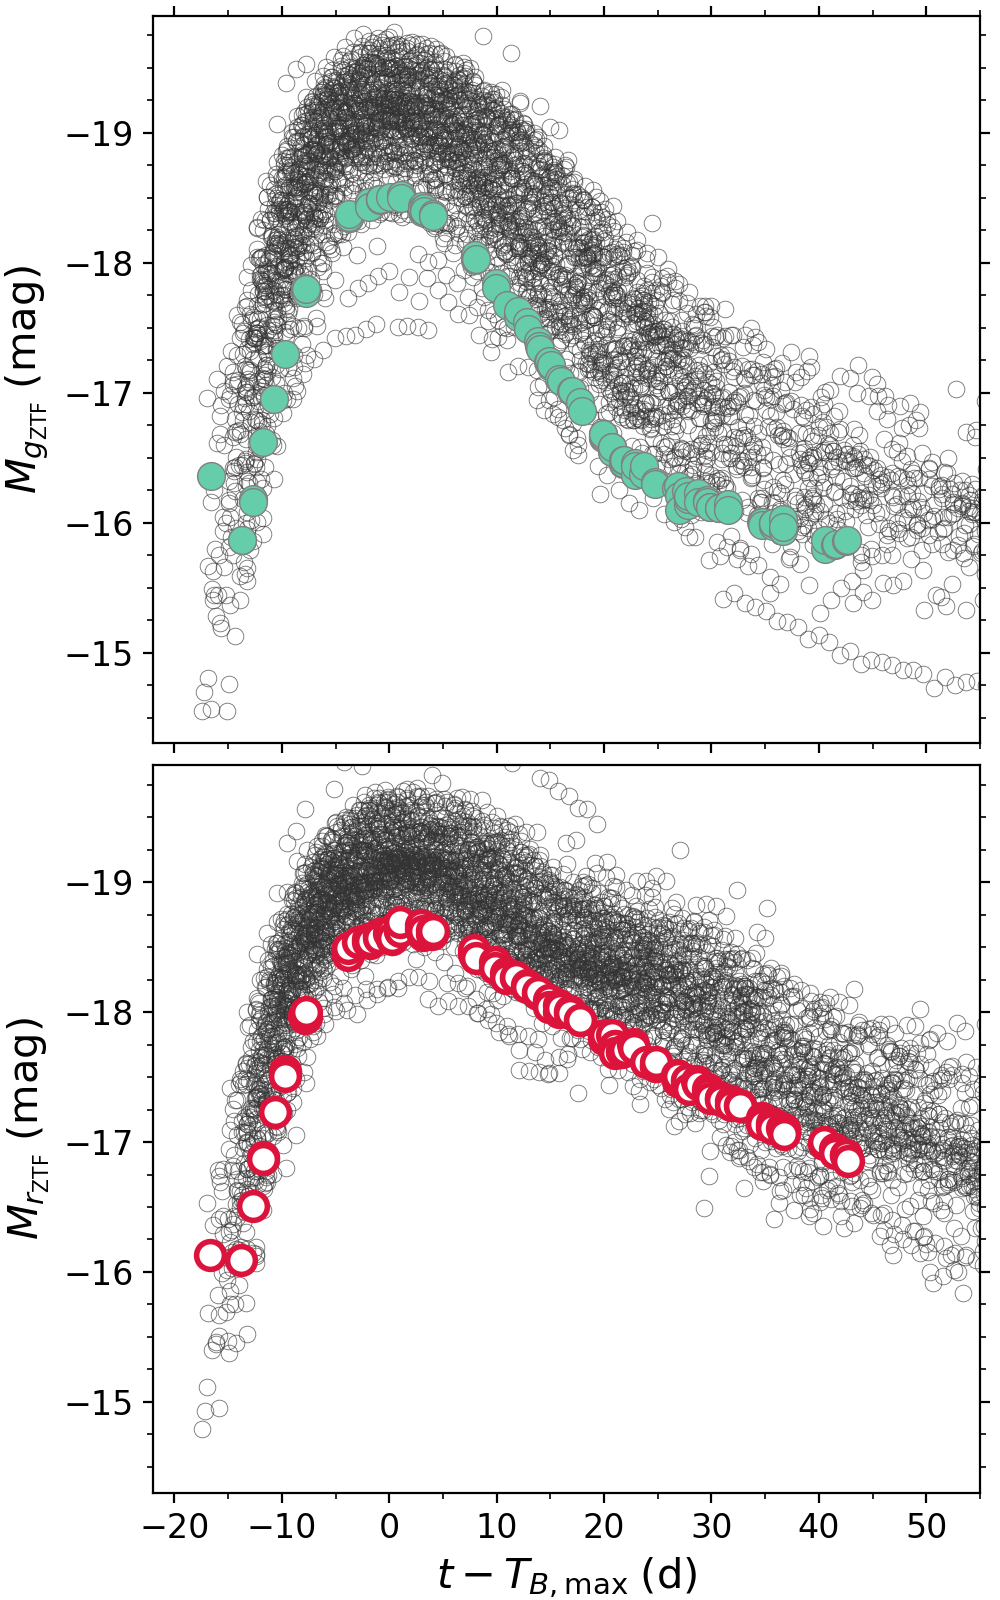

In [6]:
fig, (axg, axr) = plt.subplots(2, 1, figsize=(5,8))

for lcf in ztf18_sne_files:
    ztf_name = lcf.split('/')[-1].split('.')[0]
    this_sn = np.where(salt_df.name == ztf_name)
    if ( #(salt_df['z_source'].iloc[this_sn].values[0] == 'Msl') or 
        (salt_df['Ia subtype'].iloc[this_sn].values[0] in ['SC', 'SC*', 'Ia-CSM'])
       ):
        continue
    lc_df = pd.read_csv(lcf, delim_whitespace=True)
    
    g_obs = np.where((lc_df.fid == 1) & (lc_df.mag_unc < 0.2))
    r_obs = np.where((lc_df.fid == 2) & (lc_df.mag_unc < 0.2))
        
    axg.plot(lc_df.iloc[g_obs].t.values, 
             lc_df.iloc[g_obs].mag.values,
             'o', color='None', mec='0.2', mew=0.3,  alpha=0.7)
    axr.plot(lc_df.iloc[r_obs].t.values, 
             lc_df.iloc[r_obs].mag.values,
             'o', color='None', mec='0.2', mew=0.3,  alpha=0.7)

g_obs = np.where(abs_mag_df.filt == 'g')
axg.plot(abs_mag_df.t_restframe.iloc[g_obs].values + t_fl, 
         abs_mag_df.abs_mag.iloc[g_obs].values, 
         sym_dict[1], color=mark_color_dict[1],
         mec=mec_dict[1], mew=mew_dict[1],
         zorder = zorder_dict[1], ms=10)
r_obs = np.where(abs_mag_df.filt == 'r')
axr.plot(abs_mag_df.t_restframe.iloc[r_obs].values + t_fl, 
         abs_mag_df.abs_mag.iloc[r_obs].values, 
         sym_dict[2], color=mark_color_dict[2], 
         mec=mec_dict[2], mew=mew_dict[2],
         zorder = zorder_dict[2], ms=10)

for ax in [axg, axr]:
    ax.set_xlim(-22, 55)
    ax.set_ylim(-14.3, -19.9)
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    
axg.tick_params(which='both', top=True, right=True, labelsize=12)
axr.tick_params(which='both', right=True, labelsize=12)
axg.set_xticklabels([])
axg.set_ylabel(r'$M_{g_\mathrm{ZTF}} \;(\mathrm{mag})$', fontsize=15)
axr.set_ylabel(r'$M_{r_\mathrm{ZTF}} \;(\mathrm{mag})$', fontsize=15)
axr.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize=15)

fig.subplots_adjust(top=0.99, right=0.98, left=0.153, bottom=0.067, hspace=0.03)
fig.savefig('../paper/figures/abs_mag.pdf')

In [7]:
salt_df['Ia subtype'].iloc[np.where(salt_df.name == ztf_name)].values[0]

'99aa-like'

## Add K corrections and host reddening

K corrections and host reddening can lead to a lot of scatter in the SN Ia light curves. We have the info to apply these corrections as necessary.

In [8]:
ebv_snoopy = pd.read_csv('../data/comp_sne/ztf_ia_2018/ebv_sbv.txt', 
                       delim_whitespace=True)

In [9]:
ebv_snoopy.head(5)

,sn,ebv,e_ebv,sbv,e_sbv
0,ZTF18aauhxce,0.182140,0.019131,1.203023,0.027713
1,ZTF18aavrzxp,0.048281,0.009947,0.825408,0.010229
2,ZTF18abckujq,0.008263,0.012123,1.037151,0.026442
3,ZTF18aaxsioa,0.150005,0.005636,0.795653,0.003822
4,ZTF18abimsyv,0.032537,0.008883,1.123786,0.014084


In [10]:
for lcf in ztf18_sne_files:
    ztf_name = lcf.split('/')[-1].split('.')[0]
    this_sn = np.where(salt_df.name == ztf_name)

    ebv_host = ebv_snoopy.iloc[np.where(ebv_snoopy.sn == ztf_name)].ebv.values[0]
    a_g = extinction_cal.calALambda(4722.74, 3.1, ebv_host)
    a_r = extinction_cal.calALambda(6339.61, 3.1, ebv_host)


<IPython.core.display.Javascript object>


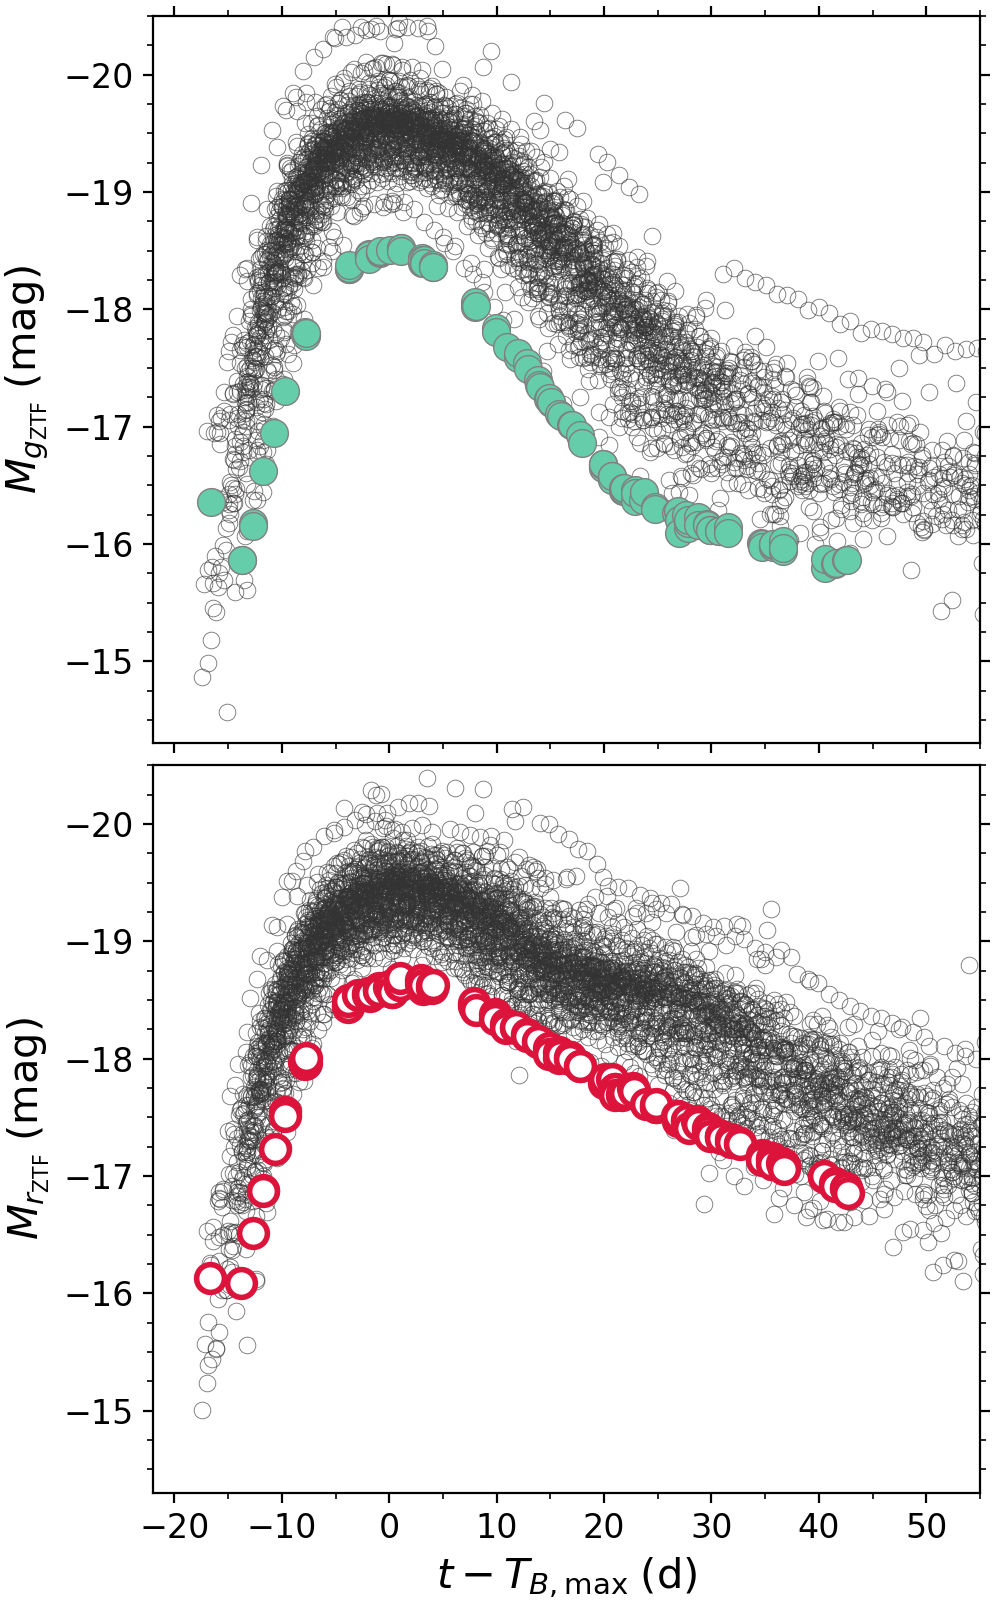

In [11]:
fig, (axg, axr) = plt.subplots(2, 1, figsize=(5,8))

for lcf in ztf18_sne_files:
    ztf_name = lcf.split('/')[-1].split('.')[0]
    this_sn = np.where(salt_df.name == ztf_name)
    if ( #(salt_df['z_source'].iloc[this_sn].values[0] == 'Msl') or 
        (salt_df['Ia subtype'].iloc[this_sn].values[0] in ['SC', 'SC*', 'Ia-CSM'])
       ):
        continue
    
    ebv_host = ebv_snoopy.iloc[np.where(ebv_snoopy.sn == ztf_name)].ebv.values[0]
    if ebv_host > 0:
        a_g = extinction_cal.calALambda(4722.74, 3.1, ebv_host)
        a_r = extinction_cal.calALambda(6339.61, 3.1, ebv_host)
    else:
        a_g = 0
        a_r = 0
    
    lc_df = pd.read_csv(lcf, delim_whitespace=True)
    
    g_obs = np.where((lc_df.fid == 1) & (lc_df.mag_unc < 0.2))
    r_obs = np.where((lc_df.fid == 2) & (lc_df.mag_unc < 0.2))
        
    axg.plot(lc_df.iloc[g_obs].t.values, 
             lc_df.iloc[g_obs].mag.values - a_g,
             'o', color='None', mec='0.2', mew=0.3,  alpha=0.7)
    axr.plot(lc_df.iloc[r_obs].t.values, 
             lc_df.iloc[r_obs].mag.values - a_r,
             'o', color='None', mec='0.2', mew=0.3,  alpha=0.7)
    

g_obs = np.where(abs_mag_df.filt == 'g')
axg.plot(abs_mag_df.t_restframe.iloc[g_obs].values + t_fl, 
         abs_mag_df.abs_mag.iloc[g_obs].values, 
         sym_dict[1], color=mark_color_dict[1],
         mec=mec_dict[1], mew=mew_dict[1],
         zorder = zorder_dict[1], ms=10)
r_obs = np.where(abs_mag_df.filt == 'r')
axr.plot(abs_mag_df.t_restframe.iloc[r_obs].values + t_fl, 
         abs_mag_df.abs_mag.iloc[r_obs].values, 
         sym_dict[2], color=mark_color_dict[2], 
         mec=mec_dict[2], mew=mew_dict[2],
         zorder = zorder_dict[2], ms=10)

for ax in [axg, axr]:
    ax.set_xlim(-22, 55)
    ax.set_ylim(-14.3, -20.5)
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    
axg.tick_params(which='both', top=True, right=True, labelsize=12)
axr.tick_params(which='both', right=True, labelsize=12)
axg.set_xticklabels([])
axg.set_ylabel(r'$M_{g_\mathrm{ZTF}} \;(\mathrm{mag})$', fontsize=15)
axr.set_ylabel(r'$M_{r_\mathrm{ZTF}} \;(\mathrm{mag})$', fontsize=15)
axr.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize=15)

fig.subplots_adjust(top=0.99, right=0.98, left=0.153, bottom=0.067, hspace=0.03)
# fig.savefig('../paper/figures/abs_mag_host_ebv.pdf')

<IPython.core.display.Javascript object>


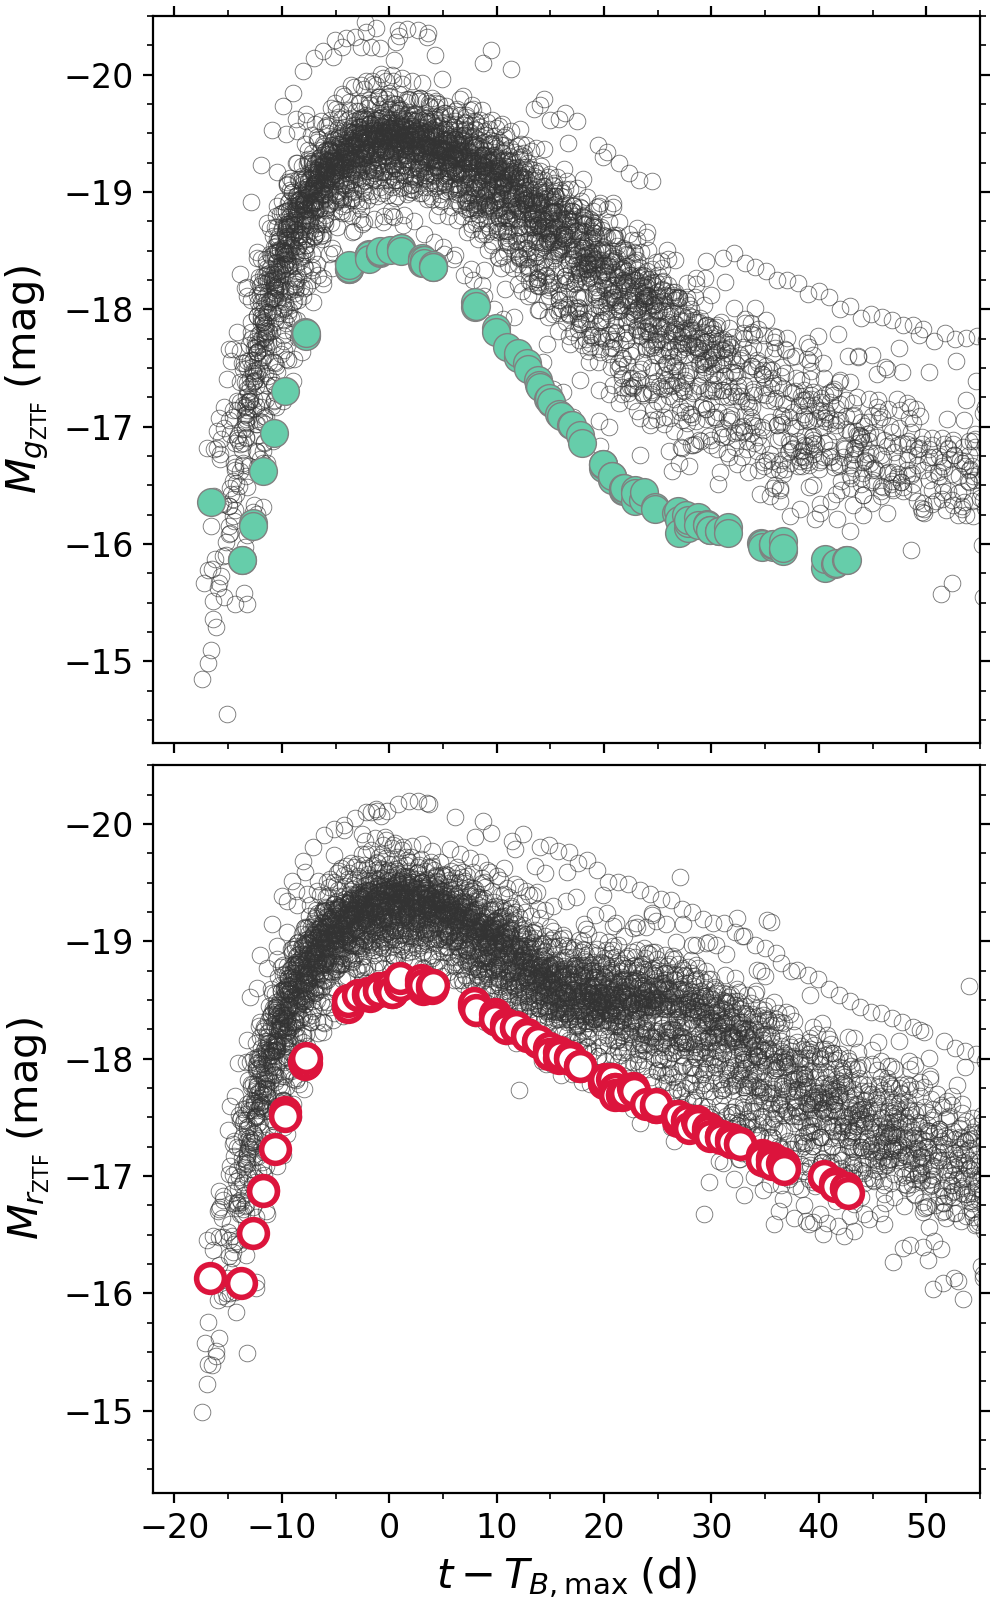

ZTF18abgmcmv
ZTF18abjdjge
ZTF18aasesgl
121 SNe are in this figure


In [12]:
fig, (axg, axr) = plt.subplots(2, 1, figsize=(5,8))

n_sn = 0

for lcf in ztf18_sne_files:
    ztf_name = lcf.split('/')[-1].split('.')[0]
    this_sn = np.where(salt_df.name == ztf_name)
    if ( #(salt_df['z_source'].iloc[this_sn].values[0] == 'Msl') or 
        (salt_df['Ia subtype'].iloc[this_sn].values[0] in ['SC', 'SC*', 'Ia-CSM'])
       ):
        continue
    
    ebv_host = ebv_snoopy.iloc[np.where(ebv_snoopy.sn == ztf_name)].ebv.values[0]
    if ebv_host > 0:
        a_g = extinction_cal.calALambda(4722.74, 3.1, ebv_host)
        a_r = extinction_cal.calALambda(6339.61, 3.1, ebv_host)
    else:
        a_g = 0
        a_r = 0
    
    lc_df = pd.read_csv(lcf, delim_whitespace=True)
    
    g_obs = np.where((lc_df.fid == 1) & (lc_df.mag_unc < 0.2))
    r_obs = np.where((lc_df.fid == 2) & (lc_df.mag_unc < 0.2))
    
    # K corrections
    gKcorr = pd.read_csv('../data/comp_sne/ztf_ia_2018/{}_gKcorr.ascii'.format(ztf_name), 
                     delim_whitespace=True, names=['MJD', 'kmag'])
    rKcorr = pd.read_csv('../data/comp_sne/ztf_ia_2018/{}_rKcorr.ascii'.format(ztf_name), 
                         delim_whitespace=True, names=['MJD', 'kmag'])
    mjd_obs = (lc_df.t.values)*(1+salt_df.z_adopt.iloc[this_sn].values) + salt_df.t0_g_adopted.iloc[this_sn].values - 2400000.5
    
    sn_gkcorr = np.zeros_like(lc_df.iloc[g_obs].t.values)
    sn_rkcorr = np.zeros_like(lc_df.iloc[r_obs].t.values)

    for obs_num, mjd in enumerate(mjd_obs[g_obs]):
        if np.min(np.abs(mjd - gKcorr.MJD.values)) < 0.4:
            sn_gkcorr[obs_num] = gKcorr.kmag.values[np.argmin(np.abs(mjd - gKcorr.MJD.values))]

    for obs_num, mjd in enumerate(mjd_obs[r_obs]):
        if np.min(np.abs(mjd - rKcorr.MJD.values)) < 0.4:
            sn_rkcorr[obs_num] = rKcorr.kmag.values[np.argmin(np.abs(mjd - rKcorr.MJD.values))]
    
    has_g_Kcorr = np.where(sn_gkcorr != 0)
    axg.plot(lc_df.iloc[g_obs].t.values[has_g_Kcorr], 
             lc_df.iloc[g_obs].mag.values[has_g_Kcorr] - a_g - sn_gkcorr[has_g_Kcorr],
             'o', color='None', mec='0.2', mew=0.3,  alpha=0.7)
    if min(lc_df.iloc[g_obs].mag.values - a_g - sn_gkcorr) < -20.3:
        print(ztf_name)
    has_r_Kcorr = np.where(sn_rkcorr != 0)
    axr.plot(lc_df.iloc[r_obs].t.values[has_r_Kcorr], 
             lc_df.iloc[r_obs].mag.values[has_r_Kcorr] - a_r - sn_rkcorr[has_r_Kcorr],
             'o', color='None', mec='0.2', mew=0.3,  alpha=0.7)
#     if ztf_name == 'ZTF18abdmgab':
#         axg.plot(lc_df.iloc[g_obs].t.values[has_g_Kcorr], 
#                  lc_df.iloc[g_obs].mag.values[has_g_Kcorr] - a_g - sn_gkcorr[has_g_Kcorr],
#                  '*', color='DarkOrange', mec='0.2', mew=0.3,  alpha=0.7, ms=10, zorder=100)
#         axr.plot(lc_df.iloc[r_obs].t.values[has_r_Kcorr], 
#                  lc_df.iloc[r_obs].mag.values[has_r_Kcorr] - a_r - sn_rkcorr[has_r_Kcorr],
#                  '*', color='DarkOrange', mec='0.2', mew=0.3,  alpha=0.7, ms=10, zorder=100)        
    n_sn += 1

g_obs = np.where(abs_mag_df.filt == 'g')
axg.plot(abs_mag_df.t_restframe.iloc[g_obs].values + t_fl, 
         abs_mag_df.abs_mag.iloc[g_obs].values, 
         sym_dict[1], color=mark_color_dict[1],
         mec=mec_dict[1], mew=mew_dict[1],
         zorder = zorder_dict[1], ms=10)
r_obs = np.where(abs_mag_df.filt == 'r')
axr.plot(abs_mag_df.t_restframe.iloc[r_obs].values + t_fl, 
         abs_mag_df.abs_mag.iloc[r_obs].values, 
         sym_dict[2], color=mark_color_dict[2], 
         mec=mec_dict[2], mew=mew_dict[2],
         zorder = zorder_dict[2], ms=10)

for ax in [axg, axr]:
    ax.set_xlim(-22, 55)
    ax.set_ylim(-14.3, -20.5)
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(0.25))
    
axg.tick_params(which='both', top=True, right=True, labelsize=12)
axr.tick_params(which='both', right=True, labelsize=12)
axg.set_xticklabels([])
axg.set_ylabel(r'$M_{g_\mathrm{ZTF}} \;(\mathrm{mag})$', fontsize=15)
axr.set_ylabel(r'$M_{r_\mathrm{ZTF}} \;(\mathrm{mag})$', fontsize=15)
axr.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize=15)

fig.subplots_adjust(top=0.99, right=0.98, left=0.153, bottom=0.067, hspace=0.03)
fig.savefig('../paper/figures/abs_mag_host_ebv_kcorr.pdf')

print('{} SNe are in this figure'.format(n_sn))